In [58]:
import torch
import torch.nn as nn 
import torchvision as tv 
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm



In [38]:
transformation = tv.transforms.Compose(
    [
        tv.transforms.ToTensor()  # Pil To Tesnor


    ]

)

In [39]:
ds_mnist = tv.datasets.MNIST('./datasets' , download = True , transform= transformation )



In [40]:
print(len(ds_mnist))
print(ds_mnist[0])

#60000 photos 28 x 28 , tuple ( image , label )

60000
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

In [14]:
print(ds_mnist[0])
ds_mnist[0][0].shape # After transformation

torch.Size([1, 28, 28])

In [19]:
ds_mnist[0][0].numpy()[0].shape  #Почему то если написать [0] после нумпая то удаляется первая размерность

(28, 28)

In [23]:
ds_mnist[0][0].numpy().squeeze(0).shape # Сквиз тоже все по кайфу удалил

(28, 28)

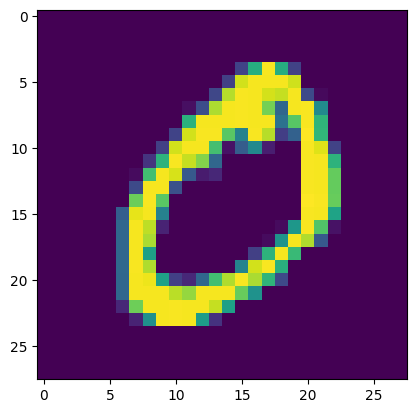

In [24]:
plt.imshow( ds_mnist[1][0].numpy().squeeze(0))  # 1 картинка

#ds_mnist  - датасет [1] - первый кортеж [0] - 1 элемент в кортеже (картинка) .numpy() - трансфер нумпай .squeeze(0) - удалить размерностть 1 

In [26]:
batch_size = 16
dataloader = torch.utils.data.DataLoader(ds_mnist ,
                                         batch_size = batch_size ,
                                         shuffle = True , 
                                         num_workers= 0 , 
                                         drop_last = True 
                                         )
# num workers - количество парралельный потоков , 0 - все
# Drop Last не дает генерировать маленькие датасеты (??)


In [31]:
for image , label  in dataloader :
  print(image.shape)
  print(label)
  break


  # BCHW

torch.Size([16, 1, 28, 28])
tensor([4, 2, 4, 9, 3, 2, 6, 6, 0, 2, 4, 6, 3, 1, 2, 9])


Функция активации добавляет нелинейности

In [41]:
class Neural_numbers(nn.Module):
  #Arch и ее блоки
  def __init__(self):
        # импортим свойства nn.Module
        super().__init__() 
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(28*28 , 100)
        self.linear2 = nn.Linear( 100 , 10 )

        self.act = nn.ReLU()
        
       # self.model = nn.Sequential( linear1 , act , linear2)
   # как будут перемещаться тензоры в нейронной сети      
  def forward(self, x): # x - tensor 
    out = self.flat(x)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)

    return out
        

        

In [42]:
model = Neural_numbers()

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters() , lr = 1e-3 , momentum = 0.9)

In [89]:
def accuracy(pred , label) :
    
    answer = F.softmax(pred.detach()).numpy().argmax(1)  == label.numpy().argmax(1)
    
    return answer.mean()

In [90]:
epochs = 10 

for epoch in range(epochs):

  loss_val = 0 
  acc_val = 0 

  for img , label in (pbar := tqdm(dataloader)) : # просто запомнить визуализация
    optimizer.zero_grad() #  Обнови градиенты (в нуль их так как новые будем считать, чтобы они не наслаивались)
    label = nn.functional.one_hot( label , 10 ).float() # 1 - > [ 1, 0 ... 0 ]
    pred = model(img) # vector вероятностей [ 0 , 0 , 0 , 1 ... 0 ] для тройки

    loss = loss_fn(pred , label) # мы сделали pred & label одного вида чтобы их сравнить


    loss.backward() # считает градиенты

    loss_item = loss.item()
    loss_val += loss_item

    acc_current = accuracy(pred , label)
    acc_val  += acc_current
    optimizer.step() # шагаем оптимайзером , считаем веса 

  
   # .4 - 4 знака после запятой .4f - norm forma , .4e - nauchnaya forma 
    pbar.set_description(f'loss : {loss_item:.4f}\taccuracy : {acc_current:.3f}')  # ПРОСТО ЗАПОМНИТЬ прогресс лосса 
  print( f'epoch {epoch + 1 }' , f' loss_val : {loss_val / len(dataloader) }'
  , f'acc_val : {acc_val / len(dataloader)}')

  0%|          | 0/3750 [00:00<?, ?it/s]<ipython-input-89-758b855bc9b3>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1)  == label.numpy().argmax(1)
loss : 0.0044	accuracy : 1.000: 100%|██████████| 3750/3750 [00:27<00:00, 138.16it/s]


epoch 1  loss_val : 0.06205225557114463 acc_val : 0.9828166666666667


loss : 0.0620	accuracy : 1.000: 100%|██████████| 3750/3750 [00:28<00:00, 129.44it/s]


epoch 2  loss_val : 0.05967033684705384 acc_val : 0.9836


loss : 0.0074	accuracy : 1.000: 100%|██████████| 3750/3750 [00:27<00:00, 135.02it/s]


epoch 3  loss_val : 0.057139749604742975 acc_val : 0.9843666666666666


loss : 0.0493	accuracy : 1.000: 100%|██████████| 3750/3750 [00:27<00:00, 135.95it/s]


epoch 4  loss_val : 0.055188337854187315 acc_val : 0.9849833333333333


loss : 0.8777	accuracy : 0.938: 100%|██████████| 3750/3750 [00:27<00:00, 137.03it/s]


epoch 5  loss_val : 0.05320642729131505 acc_val : 0.9857833333333333


loss : 0.0007	accuracy : 1.000: 100%|██████████| 3750/3750 [00:26<00:00, 139.12it/s]


epoch 6  loss_val : 0.051216599989434085 acc_val : 0.9866666666666667


loss : 0.0037	accuracy : 1.000: 100%|██████████| 3750/3750 [00:27<00:00, 138.27it/s]


epoch 7  loss_val : 0.04952727123949056 acc_val : 0.9870833333333333


loss : 0.0465	accuracy : 1.000: 100%|██████████| 3750/3750 [00:27<00:00, 138.07it/s]


epoch 8  loss_val : 0.04805616319005688 acc_val : 0.9876


loss : 0.0246	accuracy : 1.000: 100%|██████████| 3750/3750 [00:27<00:00, 137.30it/s]


epoch 9  loss_val : 0.04626491624065675 acc_val : 0.9880166666666667


loss : 0.0196	accuracy : 1.000: 100%|██████████| 3750/3750 [00:26<00:00, 138.97it/s]

epoch 10  loss_val : 0.044805342092070106 acc_val : 0.9884


In [48]:
# сколько параметров у модели / веса 

def count_parameters(model):
  return sum( p.numel() for p in model.parameters() if p.requires_grad ) 


In [49]:
count_parameters(model)

79510

In [75]:
# score func with print

def accuracy_winfo(pred , label) :
    print(pred) #  каждая отд предсказ в батче [  1.7303,  -0.8463,   1.5196,  -0.1102,  -4.0838,   6.4148,   0.0319, -2.1025,   2.8522,  -2.0271]
    print(pred.shape) # 16 x 10 предсказания одного батча 
    print(F.softmax(pred.detach())) # act func 
    print(F.softmax(pred.detach()).argmax(1) ) # в каждой из 16 выбирается наибольшее [5, 8, 4, 9, 1, 2, 6, 0, 1, 6, 1, 2, 7, 7, 2, 9]
    print(label)
    print(label.argmax(1))
    answer = F.softmax(pred.detach()).argmax(1)  == label.argmax(1)
    print(answer.sum())
    return answer.sum()

label vs label + argmax

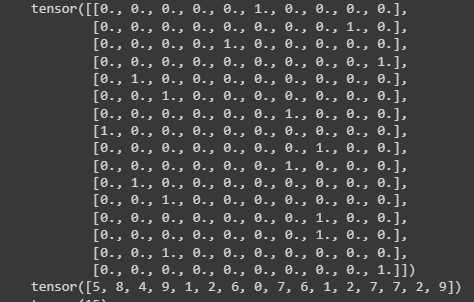

In [76]:
accuracy_winfo(pred , label)

tensor([[  1.7303,  -0.8463,   1.5196,  -0.1102,  -4.0838,   6.4148,   0.0319,
          -2.1025,   2.8522,  -2.0271],
        [  2.9952,  -2.6888,   0.9804,   0.6225,  -1.4303,  -1.0281,  -0.2374,
          -4.3710,   7.5960,  -0.3884],
        [  2.0542, -12.2870,  -3.4906,  -8.3447,  12.1696,  -1.0493,   3.7555,
           2.8799,  -1.3387,   6.0152],
        [  0.3813,  -6.7387,  -3.3074,   0.6251,   4.2898,  -1.4121,  -9.8925,
           7.2414,   0.9062,  11.3215],
        [ -0.0574,   8.8402,   0.3458,  -2.3873,  -2.7128,  -0.0928,   0.7912,
           0.8383,   2.5349,  -3.1822],
        [ -0.7725,  -0.0462,  14.8153,   3.6123,  -5.0389,  -0.1032,  -6.3916,
           3.4223,   1.5333,  -7.0453],
        [ -2.8330,  -1.2340,   0.4791,  -1.6846,   0.4104,   0.4857,  10.1592,
          -2.5872,   3.3716,  -6.5307],
        [ 10.4648,  -4.5140,   0.0227,  -5.0681,  -2.4346,   1.8060,   1.1804,
           0.3683,  -2.7857,   1.5972],
        [ -1.6718,   3.5787,   3.5531,   1.2932,

<ipython-input-75-3341f8423127>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(pred.detach())) # act func
<ipython-input-75-3341f8423127>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(pred.detach()).argmax(1) ) # в каждой из 16 выбирается наибольшее [5, 8, 4, 9, 1, 2, 6, 0, 1, 6, 1, 2, 7, 7, 2, 9]
<ipython-input-75-3341f8423127>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).argmax(1)  == label.argmax(1)


tensor(15)

In [88]:
accuracy(pred , label) # 15 out of 16

<ipython-input-87-758b855bc9b3>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1)  == label.numpy().argmax(1)


0.9375

In [102]:
img = cv2.imread('jannapicture.png' , cv2.IMREAD_GRAYSCALE )
img = np.expand_dims( img, axis = 0 )
img = np.expand_dims( img, axis = 0 )
img = img.astype(np.float32) / 255.0

In [103]:
img.shape

(1, 1, 28, 28)

In [104]:
t_img = torch.from_numpy(img)

nash_pred = model(t_img)

In [105]:
nash_pred

tensor([[ -2.3091, -14.5147,   1.0089,   6.5867,  -1.4685,  11.6470,   2.9361,
         -15.1854,  17.0669,  -2.4273]], grad_fn=<AddmmBackward0>)

In [106]:
F.softmax(nash_pred).detach().numpy()

<ipython-input-106-37a0ce516137>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(nash_pred).detach().numpy()


array([[3.8300616e-09, 1.9159164e-14, 1.0572623e-07, 2.7963883e-05,
        8.8767544e-09, 4.4079917e-03, 7.2636340e-07, 9.7968042e-15,
        9.9556327e-01, 3.4027867e-09]], dtype=float32)

In [107]:
F.softmax(nash_pred.detach()).numpy().argmax(1)

<ipython-input-107-d39544e4ce3b>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(nash_pred.detach()).numpy().argmax(1)


array([8])